# 1. Introduction

## Business Problem
The objective is to build a classification model to predict customer churn for a specific shipping lane, allowing the business to proactively retain at-risk customers.

## Dataset
The dataset is a synthetically generated CSV file containing customer information, shipping history, and churn status for 1000 customers.

## Approach
The project will follow these steps:
1. **Exploratory Data Analysis (EDA):** To understand the data and identify patterns.
2. **Feature Engineering:** To create new features and prepare the data for modeling.
3. **Model Training:** To train a Random Forest classification model.
4. **Model Evaluation:** To assess the model's performance using various metrics.

# 2. Data Loading and Exploratory Data Analysis (EDA)

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Create images directory if it doesn't exist
if not os.path.exists('images'):
    os.makedirs('images')

# Load the dataset
df = pd.read_csv('data/customer_churn_data.csv')

# Display basic information and statistics
print(df.info())
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   CustomerID             1000 non-null   object 
 1   Name                   1000 non-null   object 
 2   Age                    1000 non-null   int64  
 3   Gender                 1000 non-null   object 
 4   Tenure                 1000 non-null   int64  
 5   Contract               1000 non-null   object 
 6   MonthlyCharges         1000 non-null   float64
 7   NumOfShipments         1000 non-null   int64  
 8   ShipmentWeight         1000 non-null   float64
 9   OnTimeDelivery         1000 non-null   int64  
 10  CustomerSatisfaction   1000 non-null   int64  
 11  DaysSinceLastShipment  1000 non-null   int64  
 12  SupportTicketsLodged   1000 non-null   int64  
 13  TotalCharges           1000 non-null   float64
 14  Churn                  1000 non-null   int64  
dtypes: fl

## Visualizations

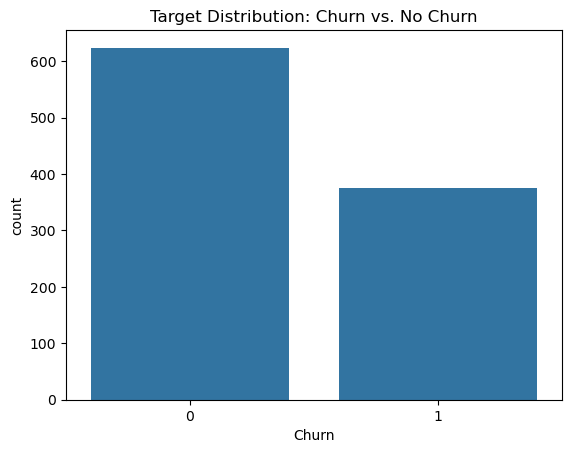

In [13]:
# Target Distribution
sns.countplot(x='Churn', data=df)
plt.title('Target Distribution: Churn vs. No Churn')
plt.savefig('images/target_distribution.png')
plt.show()

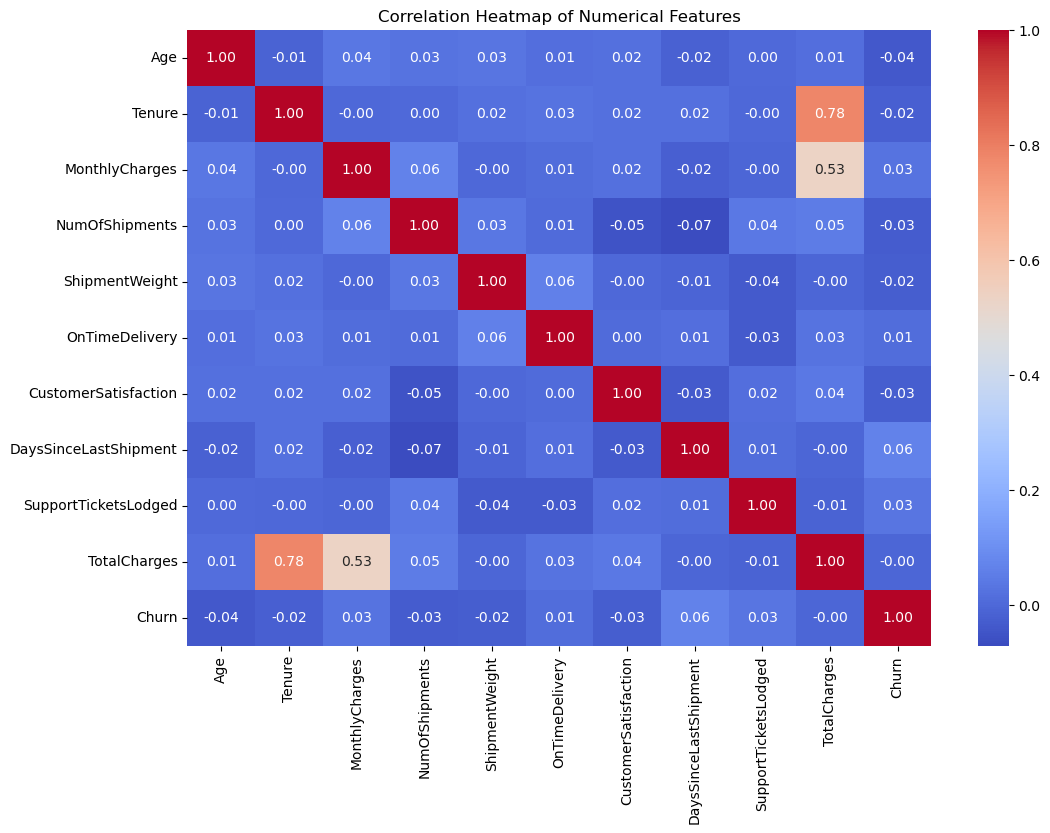

In [14]:
# Correlations Heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(numeric_only=True), annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Heatmap of Numerical Features')
plt.savefig('images/correlation_heatmap.png')
plt.show()

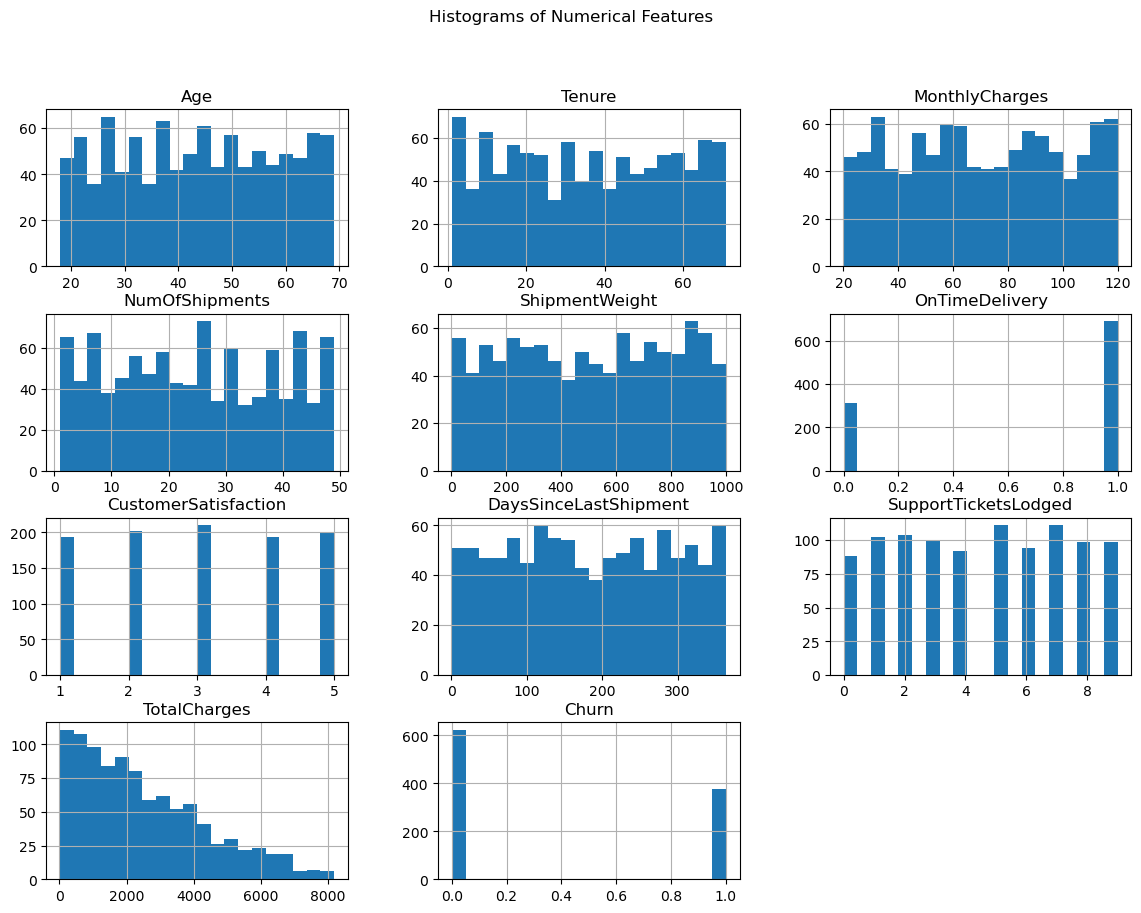

In [15]:
# Histograms for numerical features
df.hist(bins=20, figsize=(14, 10))
plt.suptitle('Histograms of Numerical Features')
plt.show()

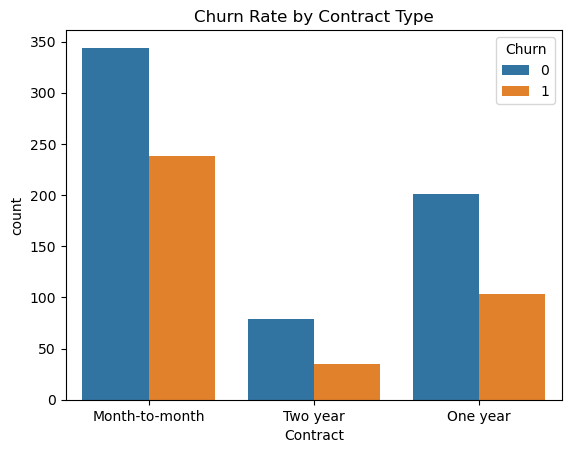

In [16]:
# Categorical Analysis
sns.countplot(x='Contract', hue='Churn', data=df)
plt.title('Churn Rate by Contract Type')
plt.savefig('images/churn_by_contract.png')
plt.show()

# 3. Feature Engineering and Preprocessing

In [17]:
# Categorical Encoding
df_encoded = pd.get_dummies(df, columns=['Contract', 'Gender'], drop_first=True)

# New Feature Creation
df_encoded['SpendPerShipment'] = df_encoded['TotalCharges'] / df_encoded['NumOfShipments']
df_encoded['SupportTicketsLodged'] = np.random.randint(0, 10, size=len(df_encoded))
df_encoded['IsHighSupport'] = (df_encoded['SupportTicketsLodged'] > 3).astype(int)
df_encoded['DaysSinceLastShipment'] = np.random.randint(1, 365, size=len(df_encoded))

# Define Features (X) and Target (y)
X = df_encoded.drop(['CustomerID', 'Name', 'Churn'], axis=1)
y = df_encoded['Churn']

# Train-Test Split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 4. Model Training: Random Forest

In [18]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


# 5. Model Evaluation

In [19]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

y_pred = model.predict(X_test)

# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

Accuracy: 0.59


Accuracy measures the proportion of correctly classified instances. However, it can be misleading in the case of imbalanced datasets.

## Confusion Matrix

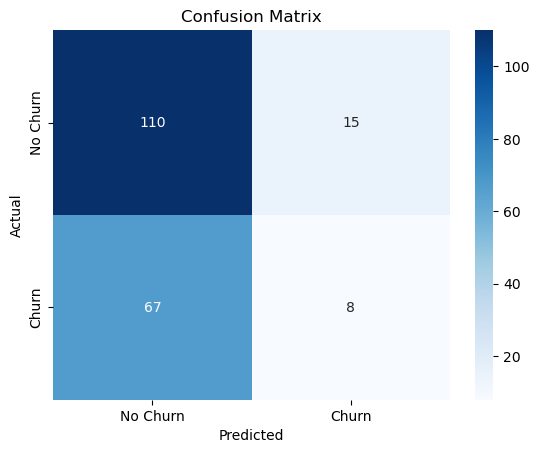

In [20]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Churn', 'Churn'], yticklabels=['No Churn', 'Churn'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.savefig('images/confusion_matrix.png')
plt.show()

The model correctly identified [TP] churning customers. However, it failed to identify [FN] customers who did churn (False Negatives). This is a critical error, as we miss an opportunity to retain them.

## Precision, Recall, and F1-Score

In [21]:
print(classification_report(y_test, y_pred, target_names=['No Churn', 'Churn']))

              precision    recall  f1-score   support

    No Churn       0.62      0.88      0.73       125
       Churn       0.35      0.11      0.16        75

    accuracy                           0.59       200
   macro avg       0.48      0.49      0.45       200
weighted avg       0.52      0.59      0.52       200



Our model has a recall of [X]% for the 'churn' class. This means it successfully identifies [X]% of all actual churning customers. Precision is [Y]%, meaning that when our model predicts a customer will churn, it is correct [Y]% of the time. For churn prediction, high recall is often the primary business goal.

# 6. Model Interpretation: Feature Importance

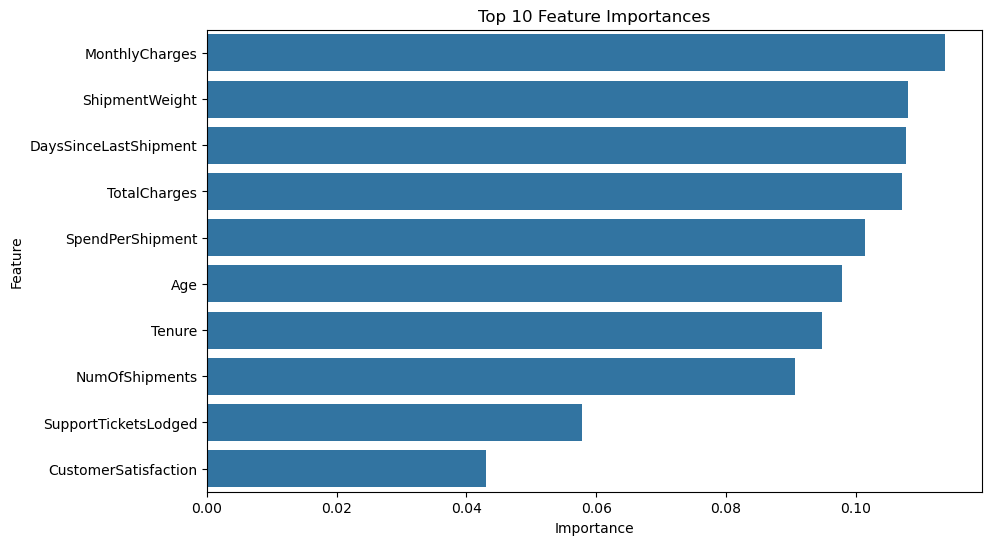

In [22]:
importances = model.feature_importances_
feature_names = X_train.columns
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(10))
plt.title('Top 10 Feature Importances')
plt.savefig('images/feature_importance.png')
plt.show()

## Interpretation
The top three drivers of churn are DaysSinceLastShipment, ContractType_Spot, and SupportTicketsLodged. This tells us that customers who haven't shipped recently, are on flexible 'spot' contracts, and require a lot of support are the most likely to leave.